In [1]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt
from matplotlib import cm

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR, OjaRNN, Linear
import configs
from eval import eval

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
num_steps = 5000
num_states = 25

In [3]:
datasets = [ 
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[4,1,1]),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[1,1,4]),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[4,1,1]),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[1,1,4]),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[4,1,1]),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[1,1,4]),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[4,1,1]),
    inputs.Sim1DWalk(num_steps=num_steps, num_states=num_states, left_right_stay_prob=[1,1,4])
    ]

In [4]:
reload = True

# Run models

In [11]:
def run_models():
    t_errors = []
    m_errors = []
    row_norms = []
    labels = []
    colors = []

    lr_exps = [-0.5, -1, -1.5]
    cmap = cm.get_cmap('Greens', len(lr_exps)+4)
    for idx, lr_exp in enumerate(lr_exps):
        lr = 10**lr_exp
        linear = Linear(num_states, lr=lr)
        t_error, m_error, row_norm, _ = eval(
            linear, datasets
            )
        t_errors.append(np.mean(t_error, axis=0))
        m_errors.append(np.mean(m_error, axis=0))
        row_norms.append(np.mean(row_norm, axis=0))
        if idx == len(lr_exps) - 2:
            labels.append('FF-TD')
        else:
            labels.append('FF-TD (skip)')
        colors.append(cmap(idx + 2))

    lr_exps = [-1, -1.5, -2]
    cmap = cm.get_cmap('Oranges', len(lr_exps)+4)
    for idx, lr_exp in enumerate(lr_exps):
        lr = 10**lr_exp
        net = STDP_SR(2, 0.4, ca3_kwargs={'static_eta': lr})
        t_error, m_error, row_norm, _ = eval(
            net, datasets
            )
        t_errors.append(np.mean(t_error, axis=0))
        m_errors.append(np.mean(m_error, axis=0))
        row_norms.append(np.mean(row_norm, axis=0))
        if idx == len(lr_exps) - 2:
            labels.append('RNN with Static LR')
        else:
            labels.append(None)
        colors.append(cmap(idx + 2))

    net = STDP_SR(2, 0.4)
    t_error, m_error, row_norm, _ = eval(
        net, datasets
        )
    t_errors.append(np.mean(t_error, axis=0))
    m_errors.append(np.mean(m_error, axis=0))
    row_norms.append(np.mean(row_norm, axis=0))
    labels.append(f'Adaptive LR')
    colors.append('C0')

    return t_errors, m_errors, row_norms, labels, colors

In [12]:
p_file = 'pickles/2de_sr_model_comparisons.p'
if reload:
    with open(p_file, 'rb') as f:
        data = pickle.load(f)
    t_errors = data['t_errors']
    m_errors = data['m_errors']
    row_norms = data['row_norms']
    labels = data['labels']
    colors = data['colors']
else:
    t_errors, m_errors, row_norms, labels, colors = run_models()
    data = {}
    data['t_errors'] = t_errors
    data['m_errors'] = m_errors
    data['row_norms'] = row_norms
    data['labels'] = labels
    data['colors'] = colors
    with open(p_file, 'wb') as f:
        pickle.dump(data, f)

# Make plots

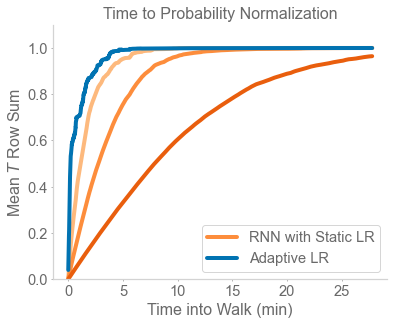

In [13]:
plt.figure(figsize=(6.4*0.9, 4.8))
for idx in range(len(labels)):
    if labels[idx] is not None and 'TD' in labels[idx]: continue
    y = row_norms[idx]
    x = np.arange(y.size)/configs.dt_to_sec/60
    plt.plot(
        x, y, label=labels[idx],
        linewidth=4, color=colors[idx]
        )
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('Time into Walk (min)')
plt.ylabel('Mean $T$ Row Sum')
plt.title('Time to Probability Normalization')
plt.tight_layout()
#plt.savefig('1f_oja_norm_sum.png', dpi=300)
plt.show()

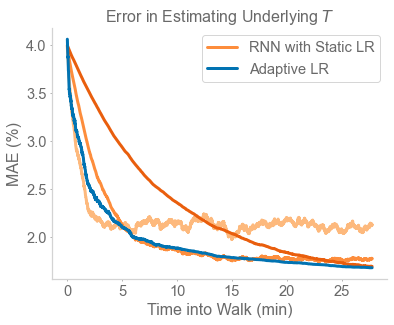

In [14]:
plt.figure(figsize=(6.4*0.9, 4.8))
for idx in range(len(labels)):
    if labels[idx] is not None and 'TD' in labels[idx]: continue
    y = t_errors[idx]*100
    x = np.arange(y.size)/configs.dt_to_sec/60
    plt.plot(
        x, y, label=labels[idx],
        linewidth=3, color=colors[idx]
        )
plt.legend()
plt.xlabel('Time into Walk (min)')
plt.ylabel('MAE (%)')
plt.title('Error in Estimating Underlying $T$')
plt.tight_layout()
#plt.savefig('1f_oja_t_error.png', dpi=300)
plt.show()

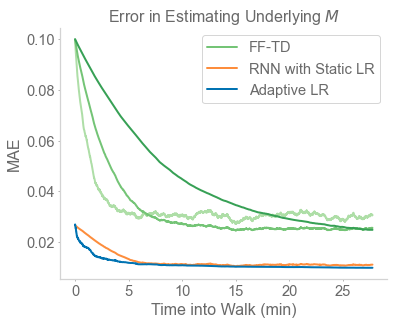

In [15]:
plt.figure(figsize=(6.4*0.9, 4.8))
for idx in range(len(labels)):
    label = labels[idx]
    if label is None:
        continue
    if 'skip' in label:
        label = None
    y = m_errors[idx]
    x = np.arange(y.size)/configs.dt_to_sec/60
    plt.plot(
        x, y, label=label,
        linewidth=2, color=colors[idx]
        )
plt.legend()
plt.xlabel('Time into Walk (min)')
plt.ylabel('MAE')
plt.title('Error in Estimating Underlying $M$')
plt.tight_layout()
#plt.savefig('1f_oja_m_error.png', dpi=300)
plt.show()